# Applying DMRG to the transverse-field Ising model

In this exercise, we want to do some physics with the MPS/MPO and DMRG implementations from the last exercises! We study the transverse-field Ising model (TFIM)
$$
H = -J\sum_i \hat{\sigma}_i^z \hat{\sigma}_{i+1}^z + h \sum_i \hat{\sigma}_i^x,
$$
with $\hat{\sigma}_{z(x)}$ the Pauli $z$ ($x$) operator. As you have already learned in the ED exercise, the TFIM undergoes a phase transition at $|h/J|=1$, from an ordered to a disordered phase.

## Part I: Preparations
### TFIM MPO
We start with the definition of the MPO representation of the TFIM Hamiltonian, with tensors

$O^{[1]}=\begin{pmatrix}   h\hat{\sigma}^x & -J\hat{\sigma}^{z} & I \end{pmatrix}$,

$O^{[i]}=\begin{pmatrix}  I & 0 & 0 \\ \hat{\sigma}^{z} & 0 & 0 \\ h\hat{\sigma}^x & -J\hat{\sigma}^z & I  \end{pmatrix}$,

$O^{[N]}=\begin{pmatrix}  I  \\ \hat{\sigma}^{z} \\ h\hat{\sigma}^{x} \end{pmatrix}$.

In [53]:
# IF YOU ARE USING GOOGLE COLAB, you need to run the following code to be able to access the dmrg.py file, which you must upload to your Google Drive
##from google.colab import drive
##drive.mount('/content/drive')
##import sys
# Append the directory to your python path using sys
##sys.path.append('/content/drive/MyDrive/ETH Computational Physics Course/Week 6 Notebooks/')
# YOU NEED TO REPLACE THE PATH I HAVE UP HERE WITH THE PATH TO YOUR dmrg.py file

# IF YOU ARE USING VS CODE INSTEAD OF COLAB, THIS ENTIRE BLOCK OF CODE IS UNNECESSARY, SO COMMENT OUT ALL THE ABOVE.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from scipy import linalg
import scipy.sparse
from scipy.sparse import linalg

from numpy import transpose as tr, conjugate as co
from scipy.linalg import expm, svd
from scipy.sparse.linalg import eigsh, LinearOperator
import math

# this is the local module with the codes from the last two exercises (with slight changes)!
from dmrg import run_DMRG, canonize, calculate_exp, random_mps

In [65]:
# if you need to know how to call the local functions, type this:
#?canonize

In [66]:
sigma_x=np.array([[0,1],[1,0]])
sigma_y=np.array([[0+0j,0-1j],[0+0j,0+1j]])
sigma_z=np.array([[1,0],[0,-1]])

def make_Ising(N, J, h):
    """
    N: number of spins
    J: coupling strength
    h: transverse field
    return a list of MPO [O1, ...ON] with dim(Oi)=(s,s,da,db); here s=2 and da=db=3
    """

    O1 = np.zeros((2,2,1,3))
    O1[:,:,0,0]=h*sigma_x
    O1[:,:,0,1]=-J*sigma_z
    O1[:,:,0,2]=np.eye(2)

    O2=np.zeros((2,2,3,3))
    O2[:,:,0,0]=np.eye(2)
    O2[:,:,1,0]=sigma_z
    O2[:,:,2,0]=h*sigma_x
    O2[:,:,2,1]=-J*sigma_z
    O2[:,:,2,2]=np.eye(2)

    O3=np.zeros((2,2,3,1))
    O3[:,:,0,0]=np.eye(2)
    O3[:,:,1,0]=sigma_z
    O3[:,:,2,0]=h*sigma_x

    O_Ising=[O1]
    for i in range(N-2):
        O_Ising.append(O2)
    O_Ising.append(O3)
    return O_Ising

### 1&2. Local expectation values

To analyse MPS quantum states, we want to calculate expectation values of local operators. For this, we first need to transform the Lambda and Gamma matrices to the local M tensors:



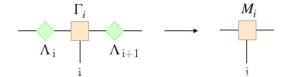

In [75]:
def get_M(Gammas, Lambdas, i):
    """
    Calculate effective single-site wave function on sites i in mixed canonical form.
    The returned array has legs 'i, vL, vR' (as one of the Gammas).
    """
    """
    for Gamma (s,da,db)
    for Lambda (da,db)
    """
    M = np.tensordot(np.diag(Lambdas[i]), Gammas[i], axes = (1,1)).transpose((1,0,2)) ####from where do i know it is 1,1 and the transpose?
    M = np.tensordot(M, np.diag(Lambdas[i+1]), axes = (2,0))
    return M

Using the local M tensors and a local operator with shape $(d, d)$, we can calculate its expectation value as:

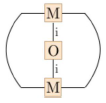

Note that the left and right part of the MPS overlap $\langle \psi | O |\psi \rangle$ reduce to identities because of the canonized form! This shows the power of the MPS representation: this expectation value with a non-canonized quantum state is very costly ($O(d^L)$). With the canonized form it reduces to $O(d^2\chi^2)$, with $\chi$ the bond dimension.

In [76]:
def site_expectation_value(Gammas, Lambdas, op):
    """
    Calculate expectation values of a local operator at each site.
    """
    result = []
    for i in range(L):
        M = get_M(Gammas, Lambdas, i)
        op_i = np.tensordot(op, M, axes = (0,0)) # (s,s) and (s,vL,vR)
        result.append(np.tensordot(M.conj(), op_i, axes=([0, 1, 2], [0, 1, 2])))
    return np.real_if_close(result) # if imaginary part is small, return real part

### 3. Antiferromagnetic order parameter
The phase transition of the TFIM can be observed by the antiferromagnetic order parameter
$$
S_{\rm AFM} = \frac{1}{L}\sum_{i=1}^L (-1)^i \hat{\sigma}_z^i.
$$
Implement a function that calculates $\langle \psi |S_{\rm AFM}|\psi \rangle$ for an MPS $|\psi\rangle$ in canonized form!

In [84]:
def afm_order_parameter(Gammas, Lambdas):
    """
    Calculate the antiferromagnetic order parameter
    S = 1/L \sum_i (-1)^i \sigma_z^i
    """
    spins = site_expectation_value(Gammas, Lambdas, sigma_z) #is already a list of expectation values
    S_AFM = np.mean([(-1)**(i+1)*spins[i] for i in range(len(spins))])
    
    return S_AFM

We can also calculate the antiferromagnetic order parameter using an MPO (though the expectation value of the MPO is less efficient to compute). Note that this MPO implementation is not needed for the rest of the exercise, but it's nice to compare!

In [ ]:
def afm_mpo(L):
    # get the MPO tensors for the antiferromagnetic order parameter!
    O1 = np.zeros((2,2,1,2))
    O1[:,:,0,0] = np.eye(2) ######################### Why do we start with the identity? ################
    O1[:,:,0,1] = -1/L * sigma_z #start with -1 bc i = 1 as start (we also use 1/L in both cases since it is not a constant but a nromalization which has to be done all the time for correct values)
    operators = [O1]
    
    for i in range(1,L-1):
        O2 = np.zeros((2,2,2,2))
        O2[:,:,0,0] = np.eye(2)
        O2[:,:,0,1] = (-1)**(i+1) /L * sigma_z
        O2[:,:,1,1] = np.eye(2)
        operators.append(O2)
    
    O3 = np.zeros((2,2,2,1))
    O3[:,:,0,0] = (-1)**L /L * sigma_z
    O3[:,:,1,0] = np.eye(2)
    operators.append(O3)

    return operators

In [123]:
AAmatrix = np.array([[1, 2, 3], [4, 5, 6]])
print(AAmatrix)
print(AAmatrix[0,1])


matrix_same_shape = np.zeros((2, 3))
print(matrix_same_shape)

[[1 2 3]
 [4 5 6]]
2
[[0. 0. 0.]
 [0. 0. 0.]]


In [116]:
def afm_order_parameter_by_mpo(Gammas, Lambdas):
    W = afm_mpo(len(Gammas))
    exp = calculate_exp(Gammas, Lambdas, W)
    return exp

Let's compare the two implementations - they should give the same result (up to some error). But the MPO calculations takes longer!

In [117]:
L = 10
chi = 100
for _ in range(10):
    M = random_mps(L, chi)
    Gammas, Lambdas = canonize(M)
    
    afm_by_local = afm_order_parameter(Gammas, Lambdas)
    afm_by_mpo = afm_order_parameter_by_mpo(Gammas, Lambdas)
    assert np.isclose(afm_by_local, afm_by_mpo, 1e-4)

In [118]:
L = 40
chi = 100
M = random_mps(L, chi)
Gammas, Lambdas = canonize(M)
%timeit afm_order_parameter(Gammas, Lambdas)
%timeit afm_order_parameter_by_mpo(Gammas, Lambdas)

21.2 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
57.2 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 4. Entanglement entropy
The $\Lambda^{[i]}$-matrices give access to the entanglement entropy of the quantum state at that bond,
$$
S_{\text{ent}}(i) = - \sum_j (\Lambda_j^{[i]})^2 \log (\Lambda_j^{[i]})^2.
$$
Implement a function that calculates the entanglement entropy given $\Lambda^{[i]}$.

In [124]:
def entanglement_entropy(Lambda):
    Lambda = Lambda[Lambda > 0]
    S = -np.sum(Lambda**2 * np.log(Lambda**2))

## Part II: DMRG of the TFIM

Before looking at the phase transition, let us understand the two limiting cases, $|h/J|=0$ and $|h/J|\rightarrow\infty$.

### 1. Classical Ising model: $h=0$
For $h=0$, the TFIM reduces to the classical Ising model and the ground state is in an ordered phase. Use DMRG to obtain the ground state of the Ising model for different bond dimensions $\chi\in [1,5]$. How does the ground state look like for the two bond dimensions? What's the ground state energy?

Ground state energy for chi=1: -39.0


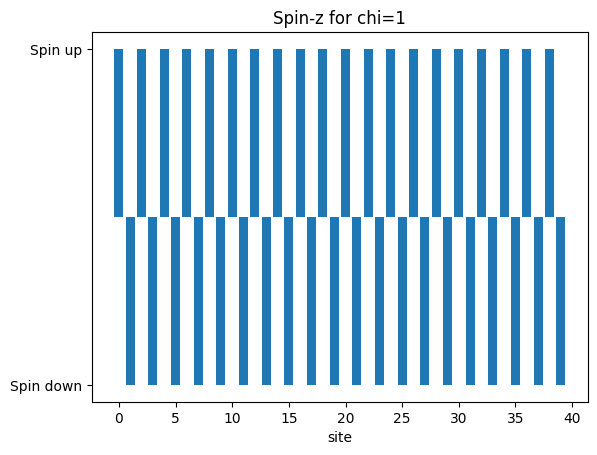

Ground state energy for chi=5: -37.000000000000036


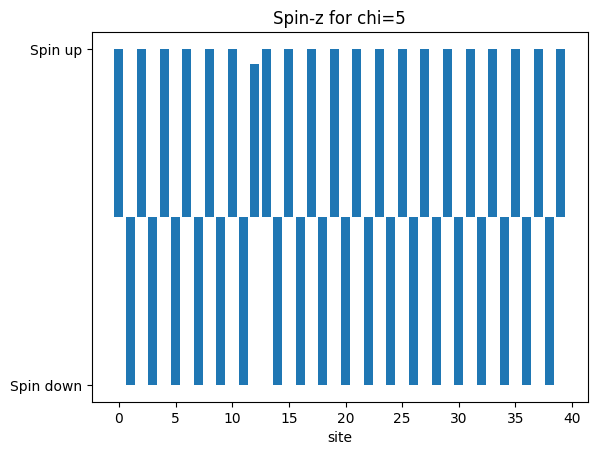

In [125]:
h = 0
J = -1
L = 40
H = make_Ising(L, J, h)
for chi in [1, 5]:
    energies, Lambdas, M = run_DMRG(H, chi=chi, verbose=False)
    print(f"Ground state energy for chi={chi}: {energies[-1]}")
    # the ground state is the antiferromagnetic state (it is degenerate)!
    gammas, lambdas = canonize(M)
    spins = site_expectation_value(gammas, lambdas, sigma_z)
    plt.bar(np.arange(0,L), spins)
    plt.title(f"Spin-z for chi={chi}")
    plt.xlabel('site')
    plt.yticks([1,-1],["Spin up", "Spin down"])
    plt.show()

### 2. Transverse field only: $J=0$
For $J=0$, the Ising term of the TFIM vanishes, and we enter a disordered phase. Use DMRG to obtain the ground state of the transverse field model for different bond dimensions $\chi\in [1,5]$. How does the ground state look like for the two bond dimensions? What's the ground state energy?

Ground state energy for chi=1: -39.99999999999987


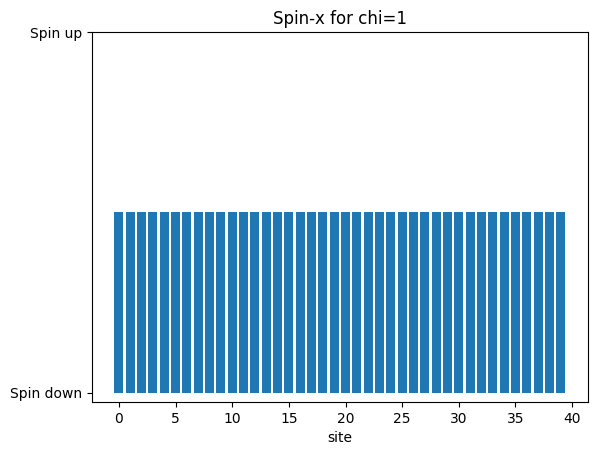

Ground state energy for chi=5: -39.99999999999993


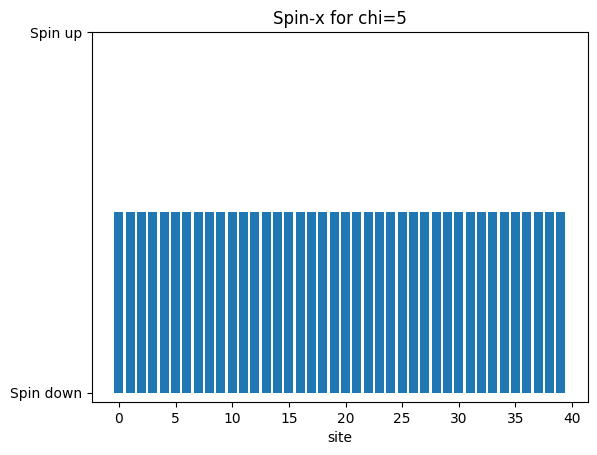

In [126]:
J = 0
h = 1
L = 40
H = make_Ising(L, J, h)
for chi in [1, 5]:
    energies, Lambdas, M = run_DMRG(H, chi=chi, verbose=False)
    print(f"Ground state energy for chi={chi}: {energies[-1]}")
    # the ground state is the ferromagnetic state with all spins aligned (it is degenerate)!
    gammas, lambdas = canonize(M)
    spins = site_expectation_value(gammas, lambdas, sigma_x)
    plt.bar(np.arange(0,L), spins)
    plt.title(f"Spin-x for chi={chi}")
    plt.xlabel('site')
    plt.yticks([1,-1],["Spin up", "Spin down"])
    plt.show()

### 3. DMRG vs ED

For small system sizes, we can compare the DMRG results to the ED results from exercise sheet 3. Compare the DMRG ground state energy error for different values of $h$ and different bond dimensions $\chi$. What can you observe?

In [127]:
h_values = np.linspace(-2., 2., 40)
ed_energies = [-16.88514149, -16.11371075, -15.34813327, -14.58954249, -13.83939066,
 -13.09957136, -12.37260294, -11.66190959, -10.97225662, -10.31041124,
  -9.68603011,  -9.11232027,  -8.60466595,  -8.17470017,  -7.82344932,
  -7.54325216,  -7.32563437,  -7.1652095,   -7.05927768,  -7.00657592,
  -7.00657592,  -7.05927768,  -7.1652095,   -7.32563437,  -7.54325216,
  -7.82344932,  -8.17470017,  -8.60466595,  -9.11232027,  -9.68603011,
 -10.31041124, -10.97225662, -11.66190959, -12.37260294, -13.09957136,
 -13.83939066, -14.58954249, -15.34813327, -16.11371075, -16.88514149]

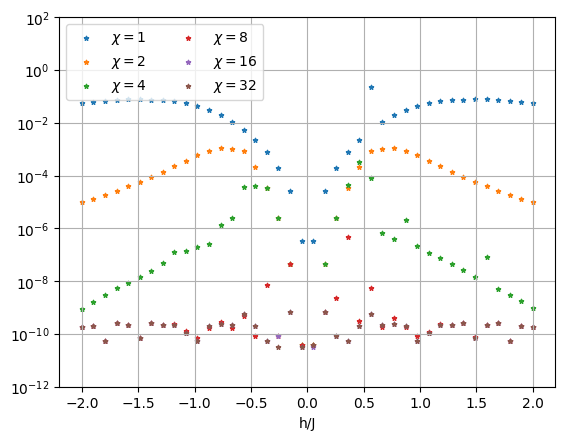

In [128]:
L = 8
J = -1
for max_chi in [1, 2, 4, 8, 16, 32]:
    energies = np.array([run_DMRG(make_Ising(L, J, h), max_chi)[0][-1] for h in h_values])
    plt.scatter(h_values, np.abs(energies - ed_energies) / np.abs(energies), marker='*', s = 10.,
                label = '$\chi = {:d}$'.format(max_chi))
plt.grid(True)
plt.yscale('log')
plt.ylim([1e-12, 1e+2])
plt.xlabel("h/J")
plt.legend(loc='upper left', ncol=2)
plt.show()

So, as expected the relative energy error decreases as the max bond dimension grows. But does not get any better beyond $\chi = 16$, because this bond dimension is already enough to encode the whole ground state exactly. <br>Note also that usually we observe the worst ground state energy approximation in the vicinity of $|h|/J = 1$, which corresponds to the phase transition (the location of the peak is slightly shifted since we work in the finite volume).

### 4. The TFIM at the phase transition

At the critical value $|h/J|=1$, the bond dimension matters for the ground state energy. Analyze the DMRG energies you obtain for different bond dimensions (if you plot the intermediate energies from the local updates, you can see the convergence!). Why does an increasing bond dimension allow for lower energies?

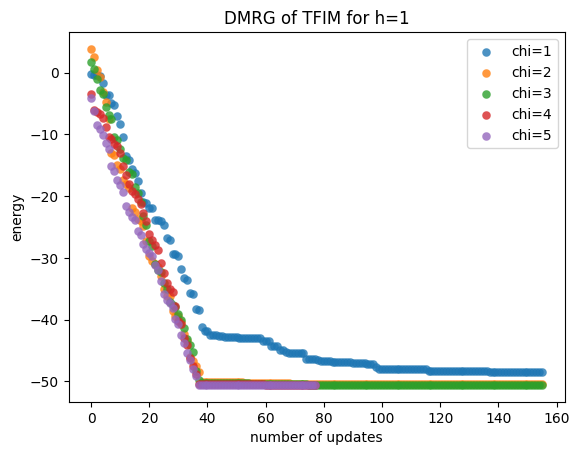

In [129]:
J = -1
h = 1
L = 40
H = make_Ising(L, J, h)
nmax = 2  # for our instructive analysis, two sweeps are enough!
chis = [1, 2, 3, 4, 5]
for chi in chis:
    energies, Lambdas, M = run_DMRG(H, chi, verbose=False, nmax=nmax)
    plt.scatter(np.arange(len(energies)), energies, label=f"chi={chi}", linewidths=0.1, alpha=0.8)
plt.title(f"DMRG of TFIM for h={h}")
plt.ylabel("energy")
plt.xlabel("number of updates")
plt.legend()

### 5. Antiferromagnetic order parameter

After our analysis of the bond dimension around the phase transistion it is time to observe the transition! We use the antiferromagnetic order parameter $S_{\rm AFM}$ that we have implemented above. Use DMRG with a high enough bond dimension to obtain $S_{\rm AFM}$ for the ground states of the TFIM with $L=40$ and $h\in [-2, 2]$. Because of the spin-flip symmetry of the antiferromagnetic state you might want to compare the absolute value $|S_{\rm AFM}|$!

In [139]:
L = 40
J = -1
chi = 16
afm_order_params = []
for h in h_values:
    H = make_Ising(L, J, h)
    energies, Lambdas, M = run_DMRG(H, chi)
    Gammas, Lambdas = canonize(M)
    afm_order_params.append(afm_order_parameter(Gammas, Lambdas))

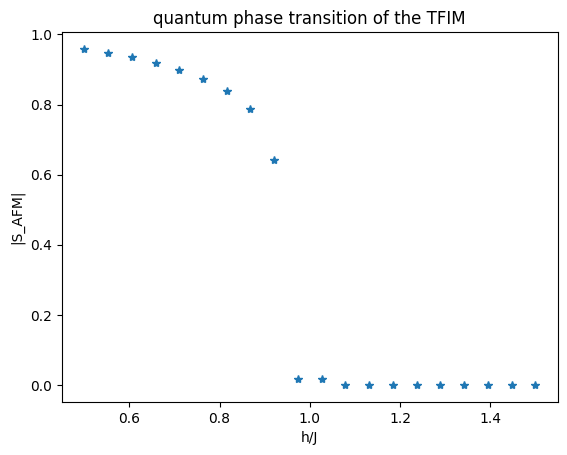

In [140]:
plt.plot(h_values, np.abs(afm_order_params), "*")
plt.title("quantum phase transition of the TFIM")
plt.xlabel("h/J")
plt.ylabel("|S_AFM|");

### 6. Entanglement entropy of the middle bond

Now let us measure the entanglement entropy over the central cut as a function of $\chi$ and $h/J$. The canonisation procedure we employ for normalisation produces the diagonal matrix of singular values $\Lambda$ (in the Vidal notation), and the entanglement entropy at bond $i$ reads:
$$\rho_i = - \text{Tr} (\Lambda_i^2 \log \Lambda_i^2).$$

Here $\Lambda_i$ is the singular value matrix produced during the right canonization step of matrixes $M_{i}$ and $M_{i - 1}$.

We take $L = 40$ and plot the entanglement entropy of the central cut in the region $0.5 \leqslant h/J \leqslant 1.5$. Due to the instability around the critical point $h/J=1$ we need to average over several DMRG runs.

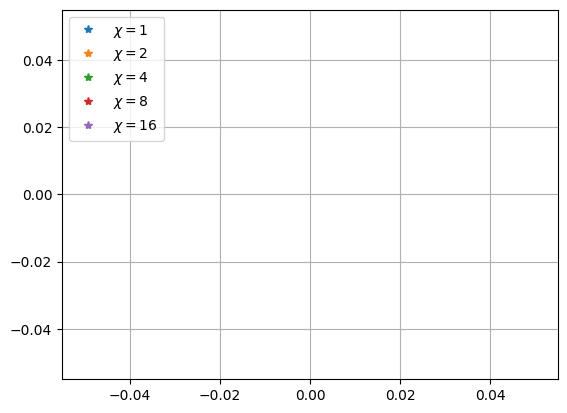

In [135]:
L = 40
middle_bond = L // 2 - 1
J = -1  # to have positive h/J
h_values = np.linspace(0.5, 1.5, 20)
nruns = 10
for max_chi in [1, 2, 4, 8, 16]:
    entropies = np.zeros((len(h_values), nruns))
    for run in range(nruns):
        Lambdas_per_h = [run_DMRG(make_Ising(L, J, h), chi=max_chi)[1] for h in h_values] #20,39,1
        #print(np.shape(Lambdas_per_h))
        entropies[:, run] = [entanglement_entropy(Lambdas[middle_bond]) for Lambdas in Lambdas_per_h] # geht durch die 20 durch, niummt den qwet 19 von 29 und interaiert es 10 mal durch
        #print(np.shape(entropies))
    entropies_per_h = np.mean(entropies, axis=1)
    plt.plot(h_values, entropies_per_h, "*", label = f'$\chi = {max_chi}$')
plt.grid(True)
plt.legend(loc='upper left', ncol=1)
plt.show()